The following is from [this article](https://medium.com/towards-artificial-intelligence/manipulating-time-series-data-in-python-49aed42685a0) in Medium.

# Table of Content:

1. Working with Time Series in Pandas
2. Basic Time Series Metrics & Resampling
3. Window Functions: Rolling & Expanding Metrics
4. Building a value-weighted index

# 1. Working with Time Series in Pandas

## 1.1. How to use data and times with pandas

The basic building block of creating a time series data in python using Pandas time stamp (`pd.Timestamp`) is shown in the example below:

In [1]:
from datetime import datetime  # To manually create dates

import pandas as pd

import numpy as np

In [2]:
datetime(2017, 1, 1)

datetime.datetime(2017, 1, 1, 0, 0)

In [3]:
time_stamp = pd.Timestamp(datetime(2017, 1, 1))

In [4]:
time_stamp

Timestamp('2017-01-01 00:00:00')

The timestamp object has many attributes that can be used to retrieve specific time information of your data such as year, and weekday. In the example below the year of the data is retrieved.

In [5]:
time_stamp.year

2017

In [6]:
time_stamp.date()

datetime.date(2017, 1, 1)

In [7]:
time_stamp.time()

datetime.time(0, 0)

The second building block is the period object. The `period` object has a `freq` attribute to store the frequency information. The default is monthly freq and you can convert from freq to another as shown in the example below.

In [8]:
period = pd.Period("2017-01")

In [9]:
period

Period('2017-01', 'M')

The output shows that the default freq is monthly freq. You can convert it into a daily freq using the code below.

In [10]:
period.asfreq("D")  # convert to daily

Period('2017-01-31', 'D')

You can also convert period to timestamp and vice versa. This is shown in the example below.

In [11]:
period.to_timestamp()

Timestamp('2017-01-01 00:00:00')

In [12]:
period.to_timestamp().to_period("M")

Period('2017-01', 'M')

You can do basic data arithmetic operations, for example starting with a period object for January 2017 at a monthly frequency, just add the number 2 to get a monthly period for March 2017. This is shown in the example below.

In [13]:
period = pd.Period("2017-01")

In [14]:
period + 2

Period('2017-03', 'M')

To create a time series you will need to create a sequence of dates. To create a sequence of Timestamps, use the pandas' function `date_range`. You need to specify a start date, and/or end date, or a number of periods. The default is daily frequency. The function returns the sequence of dates as a `DateTimeindex` with frequency information. You will recognize the first element as a pandas Timestamp.

This is shown in the example below and the output is shown in the figure below:

In [15]:
index = pd.date_range(start="2017-1-1", periods=12, freq="M")

In [16]:
index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

## 1.2. Indexing & resampling time series

The basic transformations include parsing dates provided as strings and converting the result into the matching Pandas data type called datetime64. They also include selecting subperiods of your time series, and setting or changing the frequency of the DateTimeIndex. You can change the frequency to a higher or lower value: upsampling involves increasing the time frequency, which requires generating new data. Downsampling means decreasing the time-frequency, which requires aggregating data.

To understand more about the transformations we will apply this to the [google stock prices data](https://github.com/youssefHosni/Practical-Time-Series-In-Python/tree/main/Time%20Series%20Manipulation). First, if you check the type of the date column it is an object, so we would like to convert it into a date type by the following code.

In [17]:
google = pd.read_csv("data/google.csv")

In [18]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1094 non-null   object 
 1   Close   756 non-null    float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


The date information is converted from a string (object) into a `datetime64` and also we will set the Date column as an index for the data frame as it makes it easier that to deal with the data by using the following code:

In [19]:
google["Date"] = pd.to_datetime(google["Date"])

In [20]:
google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1094 non-null   datetime64[ns]
 1   Close   756 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.2 KB


In [21]:
google.set_index("Date", inplace=True)

In [22]:
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2014-01-02 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   756 non-null    float64
dtypes: float64(1)
memory usage: 17.1 KB


To have a better intuition of what the data looks like, let's plot the prices with time using the code below:

In [23]:
import matplotlib.pyplot as plt

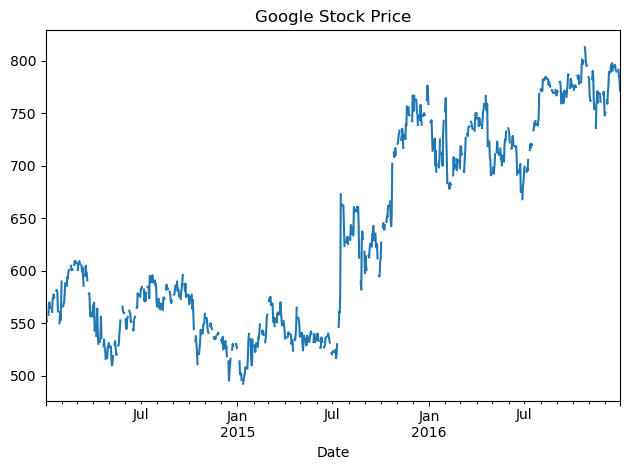

In [24]:
google["Close"].plot(title="Google Stock Price")
plt.tight_layout()
plt.show();

You can also partial indexing the data using the date index as the following example:

In [25]:
google.loc["2015", :]  # Pass string for part of date

Close
Date              
2015-01-01     NaN
2015-01-02  524.81
2015-01-03     NaN
2015-01-04     NaN
2015-01-05  513.87
...            ...
2015-12-27     NaN
2015-12-28  762.51
2015-12-29  776.60
2015-12-30  771.00
2015-12-31  758.88

[365 rows x 1 columns]

In [26]:
google.loc["2015-3":"2016-2", :]  # Slice includes last month

Close
Date              
2015-03-01     NaN
2015-03-02  571.34
2015-03-03  573.64
2015-03-04  573.37
2015-03-05  575.33
...            ...
2016-02-25  705.75
2016-02-26  705.07
2016-02-27     NaN
2016-02-28     NaN
2016-02-29  697.77

[366 rows x 1 columns]

You may have noticed that our DateTimeIndex did not have frequency information. You can set the frequency information using `.asfreq()`. The alias ‘D’ stands for calendar day frequency. As a result, the DateTimeIndex now contains many dates where the stock wasn’t bought or sold.

The example below shows converting the DateTimeIndex of the google stock data into calendar day frequency:

In [27]:
google.asfreq("D").info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2014-01-02 to 2016-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   756 non-null    float64
dtypes: float64(1)
memory usage: 17.1 KB


In [28]:
google.asfreq("D").head()

Close
Date              
2014-01-02  556.00
2014-01-03  551.95
2014-01-04     NaN
2014-01-05     NaN
2014-01-06  558.10

We can also set the DateTimeIndex to business day frequency using the same method but changing ‘D’ into ‘B’ in the `.asfreq()` method. This is shown in the example below:

In [29]:
google = google.asfreq("B")  # Change to calendar day frequency

In [30]:
google.head()

Close
Date              
2014-01-02  556.00
2014-01-03  551.95
2014-01-06  558.10
2014-01-07  568.86
2014-01-08  570.04

## 1.3. Lags, changes, and returns for stock price series

Shift or lag values back or forward back in time. `shift()`: Moving data between past & future. The default is one period into the future, but you can change it, by giving the periods variable the desired shift value.

In [31]:
google["shifted"] = google["Close"].shift()  # default: periods=1

In [32]:
google.head(3)

Close  shifted
Date                       
2014-01-02  556.00      NaN
2014-01-03  551.95   556.00
2014-01-06  558.10   551.95

To move the data into the past you can use `periods=-1` as shown in the figure below:

In [33]:
google["lagged"] = google["Close"].shift(periods=-1)

In [34]:
google.tail(3)

Close  shifted  lagged
Date                               
2016-12-28  785.05   791.55  782.79
2016-12-29  782.79   785.05  771.82
2016-12-30  771.82   782.79     NaN

One of the important properties of the stock prices data and in general in the time series data is the percentage change. It’s formula is : ((X(t)/X(t-1))-1)*100.

There are two ways to calculate it, we can use the built-in function `df.pct_change()` or use the functions `df.div.sub().mul()` and both will give the same results as shown in the example below:

In [35]:
google["change"] = google["Close"].div(google["shifted"])

In [36]:
google["return"] = google["change"].sub(1).mul(100)

In [37]:
google[["Close", "shifted", "change", "return"]].head(3)

Close  shifted    change    return
Date                                           
2014-01-02  556.00      NaN       NaN       NaN
2014-01-03  551.95   556.00  0.992716 -0.728417
2014-01-06  558.10   551.95  1.011142  1.114231

In [38]:
google["pct_change"] = google["Close"].pct_change().mul(100)

In [39]:
google[["Close", "return", "pct_change"]].head(3)

Close    return  pct_change
Date                                    
2014-01-02  556.00       NaN         NaN
2014-01-03  551.95 -0.728417   -0.728417
2014-01-06  558.10  1.114231    1.114231

We can also get multiperiod returns using the `periods` variable in the `df.pct_change()` method as shown in the following example.

In [40]:
google["return_3d"] = google["Close"].pct_change(periods=3).mul(100)

In [41]:
google[["Close", "return_3d"]].head()

Close  return_3d
Date                         
2014-01-02  556.00        NaN
2014-01-03  551.95        NaN
2014-01-06  558.10        NaN
2014-01-07  568.86   2.312950
2014-01-08  570.04   3.277471

# 2. Basic Time Series Metrics & Resampling

We will introduce resampling and how to compare different time series by normalizing their start points.

## 2.1. Resampling

In [42]:
# Creating Quarterly data
dates = pd.date_range(start="2016", periods=4, freq="Q")

In [43]:
dates

DatetimeIndex(['2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31'], dtype='datetime64[ns]', freq='Q-DEC')

In [44]:
data = range(1, 5)

In [45]:
quarterly = pd.Series(data=data, index=dates)

In [46]:
quarterly

2016-03-31    1
2016-06-30    2
2016-09-30    3
2016-12-31    4
Freq: Q-DEC, dtype: int64

Next, let’s see what happens when you up-sample your time series by converting the frequency from quarterly to monthly using `.asfreq()`. Pandas add new month-end dates to the DateTimeIndex between the existing dates. As a result, there are now several months with missing data between March and December.

In [47]:
monthly = quarterly.asfreq("M")  # to month-end frequency

In [48]:
monthly

2016-03-31    1.0
2016-04-30    NaN
2016-05-31    NaN
2016-06-30    2.0
2016-07-31    NaN
2016-08-31    NaN
2016-09-30    3.0
2016-10-31    NaN
2016-11-30    NaN
2016-12-31    4.0
Freq: M, dtype: float64

In [49]:
monthly = monthly.to_frame("baseline")  # to DataFrame

In [50]:
monthly

baseline
2016-03-31       1.0
2016-04-30       NaN
2016-05-31       NaN
2016-06-30       2.0
2016-07-31       NaN
2016-08-31       NaN
2016-09-30       3.0
2016-10-31       NaN
2016-11-30       NaN
2016-12-31       4.0

Let’s compare three ways that pandas offer to fill missing values when upsampling. The first two options involve choosing a fill method, either forward fill or backfill. The third option is to provide full value.

In [51]:
# Differnet Upsampling fill methods
monthly["ffill"] = quarterly.asfreq("M", method="ffill")  # forward fill
monthly["bfill"] = quarterly.asfreq("M", method="bfill")  # back fill
monthly["value"] = quarterly.asfreq("M", fill_value=0)
monthly

baseline  ffill  bfill  value
2016-03-31       1.0      1      1      1
2016-04-30       NaN      1      2      0
2016-05-31       NaN      1      2      0
2016-06-30       2.0      2      2      2
2016-07-31       NaN      2      3      0
2016-08-31       NaN      2      3      0
2016-09-30       3.0      3      3      3
2016-10-31       NaN      3      4      0
2016-11-30       NaN      3      4      0
2016-12-31       4.0      4      4      4

If you want a monthly DateTimeIndex that covers the full year, you can use `.reindex()`. Pandas align existing data with the new monthly values and produce missing values elsewhere. You can use the exact same fill options for `.reindex()` as you just did for `.asfreq()`.

In [52]:
# using reindex
dates = pd.date_range(start="2016", periods=12, freq="M")

In [53]:
dates

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', freq='M')

In [54]:
quarterly

2016-03-31    1
2016-06-30    2
2016-09-30    3
2016-12-31    4
Freq: Q-DEC, dtype: int64

In [55]:
quarterly.reindex(dates)

2016-01-31    NaN
2016-02-29    NaN
2016-03-31    1.0
2016-04-30    NaN
2016-05-31    NaN
2016-06-30    2.0
2016-07-31    NaN
2016-08-31    NaN
2016-09-30    3.0
2016-10-31    NaN
2016-11-30    NaN
2016-12-31    4.0
Freq: M, dtype: float64

## 2.2 Upsampling & Interpolation

The resample method follows a logic similar to `.groupby()`: It groups data within a resampling period and applies a method to this group. It takes the value that results from this method and assigns a new date within the resampling period. The new date is determined by a so-called offset, and for instance, can be at the beginning or end of the period or a custom location. You will use resample to apply methods that either fill or interpolate missing dates when up-sampling, or that aggregate when down-sampling.

We will apply the resample method to the [monthly unemployment rate](https://github.com/youssefHosni/Practical-Time-Series-In-Python/tree/main/Time%20Series%20Manipulation). First, we will upload it and spare it using the `DATE` column and make it an index.

In [56]:
unrate = pd.read_csv("data/unrate.csv", parse_dates=["DATE"], index_col="DATE")
unrate.head()

UNRATE
DATE              
2010-01-01     9.8
2010-02-01     9.8
2010-03-01     9.9
2010-04-01     9.9
2010-05-01     9.6

The 85 data points imported using read_csv since 2010 have no frequency information. An inspection of the first rows shows that the data are reported for the first of each calendar month. So let's resample it by the starting of each calendar month using both `.resample()` and `.asfreq()` methods.

In [57]:
unrate.asfreq(
    "MS"
)  # "MS" : uses the first day of month   "M" : uses the last day of month

UNRATE
DATE              
2010-01-01     9.8
2010-02-01     9.8
2010-03-01     9.9
2010-04-01     9.9
2010-05-01     9.6
...            ...
2016-09-01     4.9
2016-10-01     4.8
2016-11-01     4.6
2016-12-01     4.7
2017-01-01     4.8

[85 rows x 1 columns]

In [58]:
unrate.asfreq("MS").info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2010-01-01 to 2017-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  85 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


In [59]:
unrate.resample("MS")  # creates Resampler object

In [60]:
unrate.asfreq("MS").equals(unrate.resample("MS").asfreq())

True

Both of the methods are the same. When looking at resampling by month, we have so far focused on month-end frequency. In other words, after resampling, new data will be assigned the last calendar day for each month. There are, however, quite a few alternatives: "M" - Calendar Month End, "MS" - Calendar Month Start, "BM" - Business Month End, "BMS" - Business Month Start 

Depending on your context, you can resample to the beginning or end of either the calendar or business month.

Resampling implements the following logic: When up-sampling, there will be more resampling periods than data points. Each resampling period will have a given date offset, for instance, month-end frequency. You then need to decide how to create data for the new resampling periods. The new data points will be assigned to the date offsets. In contrast, when down-sampling, there are more data points than resampling periods. Hence, you need to decide how to aggregate your data to obtain a single value for each date offset.

## 2.3. Downsampling & aggregation

So far, we have focused on up-sampling, that is, increasing the frequency of a time series, and how to fill or interpolate any missing values. Downsampling is the opposite, is how to reduce the frequency of the time series data. This includes, for instance, converting hourly data to daily data, or daily data to monthly data. In this case, you need to decide how to summarize the existing data as 24 hours becomes a single day. Your options are familiar aggregation metrics like the mean or median, or simply the last value and your choice will depend on the context.

Let’s first use read_csv to import [air quality data](https://github.com/youssefHosni/Practical-Time-Series-In-Python/tree/main/Time%20Series%20Manipulation) from the Environmental Protection Agency. It contains the average daily ozone concentration for New York City starting in 2000. Since the imported DateTimeIndex has no frequency, let’s first assign calendar day frequency using `.resample()`. The resulting DateTimeIndex has additional entries, as well as the expected frequency information.

In [61]:
ozone = pd.read_csv("data/ozone_nyc.csv", parse_dates=["date"], index_col="date")
ozone.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6291 entries, 2000-01-01 to 2017-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.3 KB


In [62]:
ozone.head()

Ozone
date                
2000-01-01  0.004032
2000-01-02  0.009486
2000-01-03  0.005580
2000-01-04  0.008717
2000-01-05  0.013754

In [63]:
ozone = ozone.resample("D").asfreq()
ozone.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6300 entries, 2000-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ozone   6167 non-null   float64
dtypes: float64(1)
memory usage: 98.4 KB


To convert daily ozone data to monthly frequency, just apply the resample method with the new sampling period and offset. We are choosing monthly frequency with default month-end offset. Next, apply the mean method to aggregate the daily data to a single monthly value. You can see that the monthly average has been assigned to the last day of the calendar month.

In [64]:
ozone.resample("M").mean().head()

Ozone
date                
2000-01-31  0.010443
2000-02-29  0.011817
2000-03-31  0.016810
2000-04-30  0.019413
2000-05-31  0.026535

You can apply the median in the exact same fashion.

In [65]:
ozone.resample("M").median().head()

Ozone
date                
2000-01-31  0.009486
2000-02-29  0.010726
2000-03-31  0.017004
2000-04-30  0.019866
2000-05-31  0.026018

Similar to the `groupby` method, you can also apply multiple aggregations at once.

In [66]:
ozone.resample("M").agg(["mean", "std"]).head()

Ozone          
                mean       std
date                          
2000-01-31  0.010443  0.004755
2000-02-29  0.011817  0.004072
2000-03-31  0.016810  0.004977
2000-04-30  0.019413  0.006574
2000-05-31  0.026535  0.008409

Let’s visualize the resampled, aggregated Series relative to the original data at calendar-daily frequency. We’ll plot the data starting from 2016 so you can see more detail. Matplotlib allows you to plot several times on the same object by referencing the axes object that contains the plot.

<AxesSubplot: xlabel='date'>

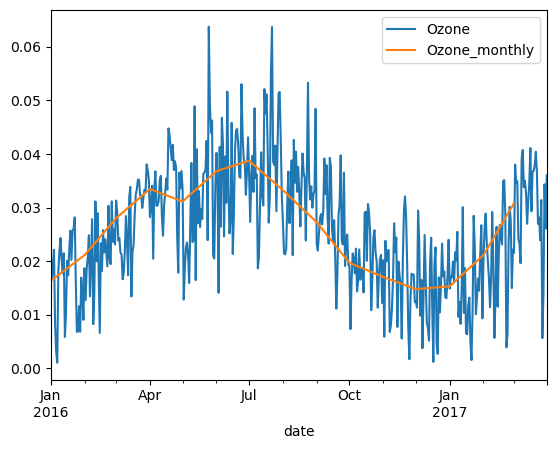

In [67]:
ozone = ozone.loc["2016":]
ax = ozone.plot()
monthly = ozone.resample("M").mean()
monthly.add_suffix("_monthly").plot(ax=ax)

The first plot is the original series, and the second plot contains the resampled series with a suffix so that the legend reflects the difference. You see that the resampled data are much smoother since the monthly volatility has been averaged out. Let’s also take a look at how to resample several series.

# 3. Window Functions: Rolling & Expanding Metrics

## 3.1. Window functions with pandas

Window functions are useful because they allow you to operate on sub-periods of your time series. In particular, window functions calculate metrics for the data inside the window. Then, the result of this calculation forms a new time series, where each data point represents a summary of several data points of the original time series. We will discuss two main types of windows: **Rolling windows** maintain the same size while they slide over the time series, so each new data point is the result of a given number of observations. **Expanding windows** grow with the time series so that the calculation that produces a new data point is the result of all previous data points.

Let’s calculate a simple moving average to see how this works in practice. We will again use google stock price data for the last several years. We will see two ways to define the rolling window:

First, we apply **rolling** with an integer window size of 30. This means that the window will contain the previous 30 observations or trading days. When you choose an integer-based window size, pandas will only calculate the mean if the window has no missing values. You can change this default by setting the `min_periods` parameter to a value smaller than the window size of 30.

In [68]:
data = pd.read_csv("data/google.csv")

In [69]:
data.set_index("Date", inplace=True)

In [70]:
data

Close
Date              
2014-01-02  556.00
2014-01-03  551.95
2014-01-04     NaN
2014-01-05     NaN
2014-01-06  558.10
...            ...
2016-12-26     NaN
2016-12-27  791.55
2016-12-28  785.05
2016-12-29  782.79
2016-12-30  771.82

[1094 rows x 1 columns]

In [71]:
# Integer-based window size
data.rolling(window=30, min_periods=1).mean()  # fixed # observations

Close
Date                  
2014-01-02  556.000000
2014-01-03  553.975000
2014-01-04  553.975000
2014-01-05  553.975000
2014-01-06  555.350000
...                ...
2016-12-26  779.575500
2016-12-27  780.145714
2016-12-28  780.946190
2016-12-29  781.515238
2016-12-30  782.171429

[1094 rows x 1 columns]

<AxesSubplot: xlabel='Date'>

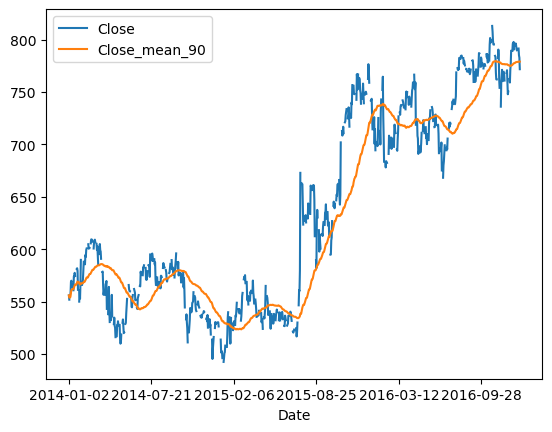

In [72]:
r90 = data.rolling(window=90, min_periods=1).mean()
data.join(r90.add_suffix("_mean_90")).plot()

To see how extending the time horizon affects the moving average, let’s add the 360 calendar day moving average.

<AxesSubplot: xlabel='Date'>

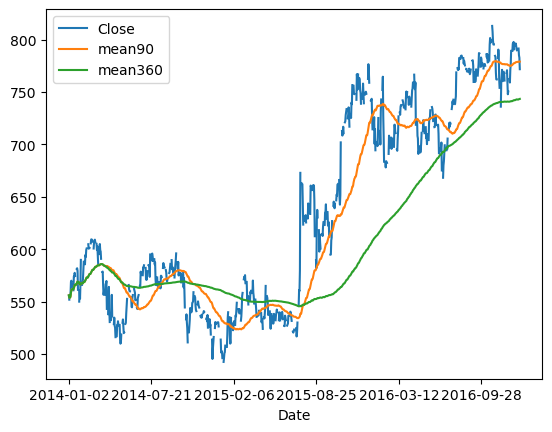

In [73]:
data["mean90"] = r90
r360 = data["Close"].rolling(window=360, min_periods=1).mean()
data["mean360"] = r360
data.plot()

The series now appears smoother still, and you can more clearly see when short-term trends deviate from longer-term trends, for instance when the 90-day average dips below the 360-day average in 2015.

Similar to `.groupby()`, you can also calculate multiple metrics at the same time, using the `.agg()` method. With a 90-day moving average and standard deviation, you can easily discern periods of heightened volatility.

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

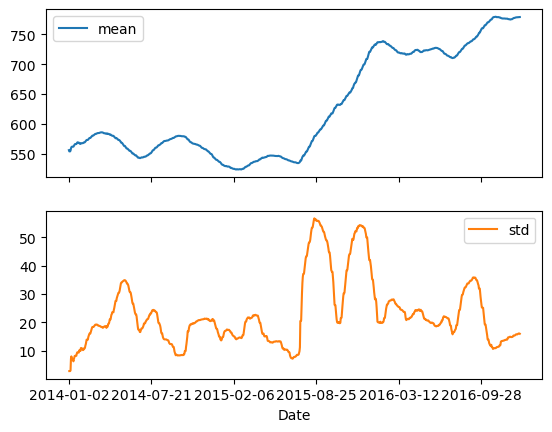

In [74]:
r = data["Close"].rolling(90, min_periods=1).agg(["mean", "std"])
r.plot(subplots=True)

Finally, let’s display a 360 calendar day rolling median, or 50 percent quantile, alongside the 10 and 90 percent quantiles. Again you can see how the ranges for the stock price have evolved over time, with some periods more volatile than others.

<AxesSubplot: xlabel='Date'>

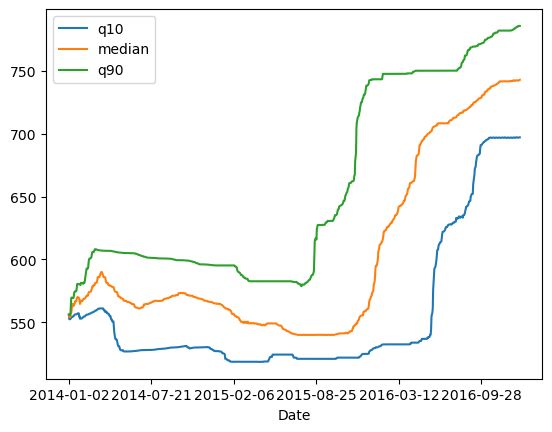

In [75]:
rolling = data["Close"].rolling(360, min_periods=1)
q10 = rolling.quantile(0.1).to_frame('q10')
median = rolling.median().to_frame('median')
q90 = rolling.quantile(0.9).to_frame('q90')
pd.concat([q10, median, q90], axis=1).plot()

## 3.2. Expanding window functions with pandas

We will move from rolling to expanding windows. You will now calculate metrics for groups that get larger to exclude all data up to the current date. Each data point of the resulting time series reflects all historical values up to that point. Expanding windows are useful to calculate for instance a cumulative rate of return, or a running maximum or minimum. In pandas, you can use either the method expanding, which works just like rolling, or in a few cases shorthand methods for the cumulative sum, product, min, and max.

We will use the [S&P500 data](https://github.com/youssefHosni/Practical-Time-Series-In-Python/tree/main/Time%20Series%20Manipulation) for the last ten years in the practical examples in this section. Let’s first take a look at how to calculate returns: The simple period return is just the current price divided by the last price minus 1. The return over several periods is the product of all period returns after adding 1 and then subtracting 1 from the product.

So for more clarification, the period return is: r(t) = (p(t)/p(t-1)) -1 and the multi-period return is: R(T) = (1+r(1))(1+r(2))……..(1+r(T)) — 1.

Pandas makes these calculations easy ‘ you have already seen the methods for percent change(`.pct_change`) and basic math (`.diff()`, `.div()`, `.mul()`), and now you’ll learn about the cumulative product.

To get the cumulative or running rate of return on the SP500, just follow the steps described above: Calculate the period return with percent change, and add 1 Calculate the cumulative product, and subtract one. You can multiply the result by 100, and plot the result in percentage terms. The code for this is shown below:

In [76]:
data = pd.read_csv("data/price.csv")

In [77]:
data.set_index("DATE", inplace=True)

In [78]:
data

SP500   Bonds     Gold    Oil
DATE                                       
2007-06-29  1503.35  402.15   648.50  70.47
2007-07-02  1519.43  402.96   650.50  71.11
2007-07-03  1524.87  402.02   657.25  71.41
2007-07-05  1525.40  400.15   655.90  71.81
2007-07-06  1530.44  399.31   647.75  72.80
...             ...     ...      ...    ...
2017-06-20  2437.03  621.84  1246.50  43.34
2017-06-21  2435.61  622.94  1247.05  42.48
2017-06-22  2434.50  622.93  1251.40  42.53
2017-06-23  2438.30  623.57  1256.30  42.86
2017-06-26  2439.07  625.00  1240.85  43.24

[2469 rows x 4 columns]

In [79]:
pr = data["SP500"].pct_change()  # period return

In [80]:
pr

DATE
2007-06-29         NaN
2007-07-02    0.010696
2007-07-03    0.003580
2007-07-05    0.000348
2007-07-06    0.003304
                ...   
2017-06-20   -0.006697
2017-06-21   -0.000583
2017-06-22   -0.000456
2017-06-23    0.001561
2017-06-26    0.000316
Name: SP500, Length: 2469, dtype: float64

In [81]:
pr_plus_one = pr.add(1)

In [82]:
pr_plus_one

DATE
2007-06-29         NaN
2007-07-02    1.010696
2007-07-03    1.003580
2007-07-05    1.000348
2007-07-06    1.003304
                ...   
2017-06-20    0.993303
2017-06-21    0.999417
2017-06-22    0.999544
2017-06-23    1.001561
2017-06-26    1.000316
Name: SP500, Length: 2469, dtype: float64

In [83]:
cumulative_return = pr_plus_one.cumprod().sub(1)

In [84]:
cumulative_return

DATE
2007-06-29         NaN
2007-07-02    0.010696
2007-07-03    0.014315
2007-07-05    0.014667
2007-07-06    0.018020
                ...   
2017-06-20    0.621066
2017-06-21    0.620122
2017-06-22    0.619383
2017-06-23    0.621911
2017-06-26    0.622423
Name: SP500, Length: 2469, dtype: float64

<AxesSubplot: xlabel='DATE'>

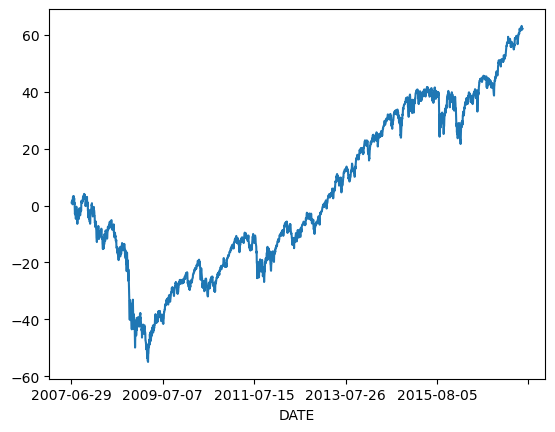

In [85]:
cumulative_return.mul(100).plot()

From the plot, we can see that the SP500 is up 60% since 2007, despite being down 60% in 2009. You can also easily calculate the running min and max of a time series: Just apply the expanding method and the respective aggregation method.

In [86]:
data["running_min"] = data["SP500"].expanding().min()
data["running_max"] = data["SP500"].expanding().max()

<AxesSubplot: xlabel='DATE'>

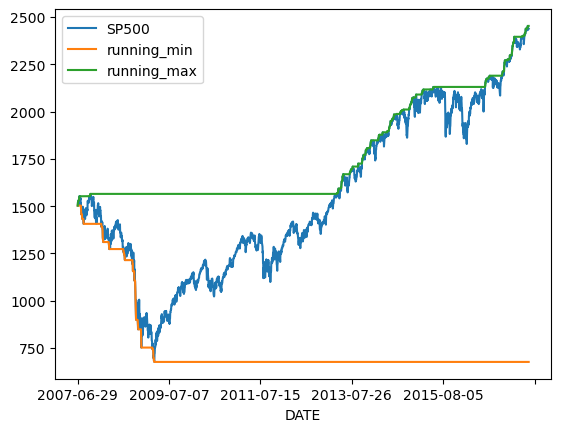

In [87]:
data[["SP500", "running_min", "running_max"]].plot()

The orange and green lines outline the min and max up to the current date for each day. You can also combine the concept of a rolling window with a cumulative calculation. Let’s calculate the rolling annual rate of return, that is, the cumulative return for all 360 calendar day periods over the ten-year period covered by the data. This cumulative calculation is not available as a built-in method. But no problem just define your own multiperiod function, and use apply it to run it on the data in the rolling window. The data in the rolling window is available to your multi_period_return function as a numpy array. Add 1 to increment all returns, apply the numpy product function, and subtract one to implement the formula from above. Just pass this function to apply after creating a 360 calendar day window for the daily returns. Multiply the rolling 1-year return by 100 to show them in percentage terms, and plot alongside the index using subplots equals True.

In [88]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [89]:
pr = data["SP500"].pct_change()  # period return

In [90]:
r = pr.rolling(360, min_periods=1).apply(multi_period_return)

In [91]:
r

DATE
2007-06-29         NaN
2007-07-02    0.010696
2007-07-03    0.014315
2007-07-05    0.014667
2007-07-06    0.018020
                ...   
2017-06-20    0.224478
2017-06-21    0.253473
2017-06-22    0.266630
2017-06-23    0.267525
2017-06-26    0.258109
Name: SP500, Length: 2469, dtype: float64

In [92]:
data['Rolling 1yr Return'] = r.mul(100)

array([<AxesSubplot: xlabel='DATE'>, <AxesSubplot: xlabel='DATE'>,
       <AxesSubplot: xlabel='DATE'>, <AxesSubplot: xlabel='DATE'>],
      dtype=object)

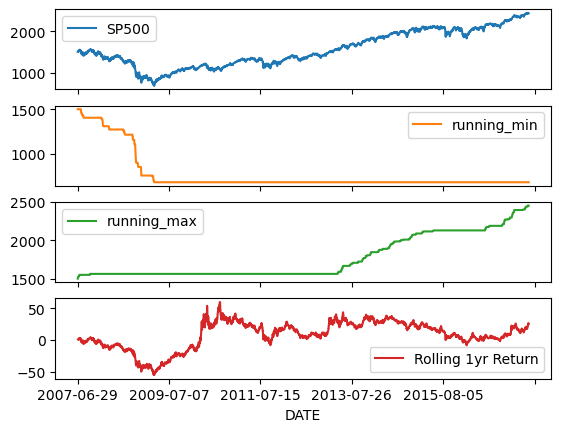

In [93]:
data[["SP500", "running_min", "running_max", "Rolling 1yr Return"]].plot(subplots=True)

The result shows the large annual return swings following the 2008 crisis.